In [1]:
from Architectures.VAE import VAE
from Data.load import load
from matplotlib import pyplot as plt
import numpy as np

In [2]:
train, test = load("Pre-processed", take=100)

Loading images: 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]


In [3]:
ae = VAE(train.shape,halvings=4, latent_dim=300, output_activation="tanh")

Interpreted image shape: (80, 96, 80, 1)
Pre-flattened latent shape: (None, 5, 6, 5, 64)



Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 80, 96, 80, 1)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ [(None, 300), (None,   │     5,833,512 │
│                                 │ 300), (None, 300)]     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 80, 96, 80, 1)  │     3,073,105 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,906,617 (33.98 MB)

 Trainable params: 8,906,617 (33.98 MB)

 Non-trainable params: 0 (0.00 B)

-0.4023423370359247 0.40234233703592465


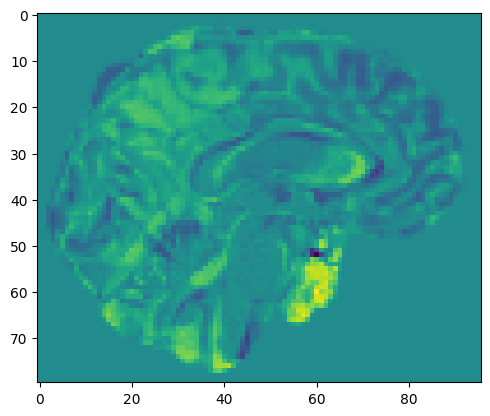

In [4]:
# Train on the diff to the mean brain instead
mean_brain = np.mean(train, axis=0)
diff_train = train - mean_brain
diff_test = test - mean_brain
plt.imshow(np.rot90(diff_train[0][40]))
print(np.min(diff_train), np.max(diff_train))

In [5]:
ae.train(diff_train,epochs=30,batch_size=20)

Epoch 1/30


ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


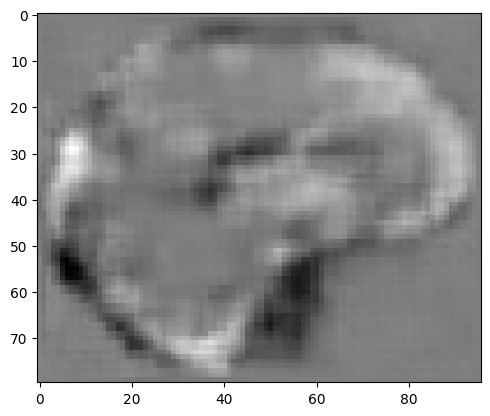

In [ ]:
latent = ae.encode(diff_test)
recon = ae.decode(latent)
plt.imshow(np.rot90(recon[0][40]),cmap="gray")

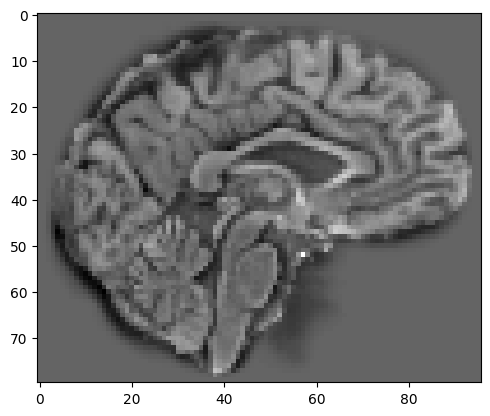

In [ ]:
plt.imshow(np.rot90(diff_test[0][40].reshape((96,80))),cmap="gray") # mean_brain[40]+

In [ ]:
from Metrics.metrics import NMSE, SSIM
SSIM(recon.reshape(diff_test.shape), diff_test)

0.47985097879764366

Retained variance 0.9821266252547503
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


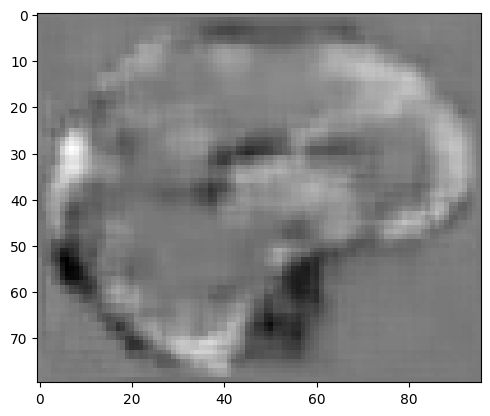

In [ ]:
from sklearn.decomposition import PCA

pca=PCA(7)
pca_latent = pca.fit_transform(latent)
print("Retained variance",sum(pca.explained_variance_ratio_))
pca_recon = ae.decode(pca.inverse_transform(pca_latent))
plt.imshow(np.rot90(pca_recon[0][40].reshape((96,80))),cmap="gray") # mean_brain[40]+

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Retained variance 0.37408386170864105
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 331ms/step


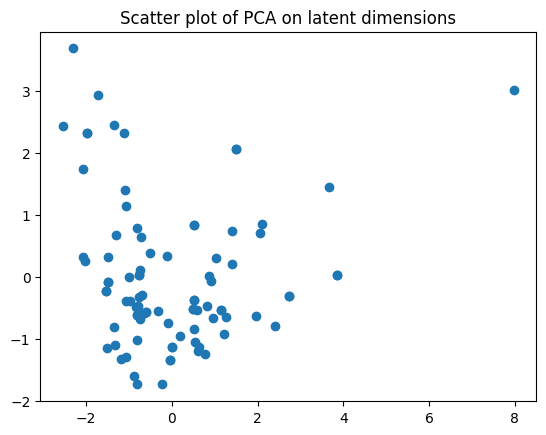

In [ ]:
pca=PCA(2) # We need ca 50. 2 components is far too little.
latent = ae.encode(diff_train)
pca_latent = pca.fit_transform(latent)
print("Retained variance",sum(pca.explained_variance_ratio_))
pca_recon = ae.decode(pca.inverse_transform(pca_latent))

plt.title("Scatter plot of PCA on latent dimensions")
plt.scatter(pca_latent[:,0],pca_latent[:,1])

There's an outlier at x>5! Let's check it out :)

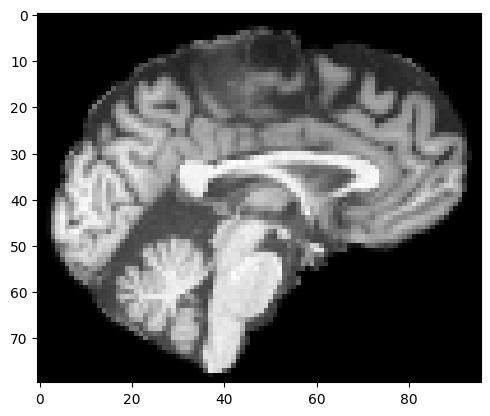

In [ ]:
idx = np.where(pca_latent[:,0] > 5)[0][0]
plt.imshow(np.rot90(train[idx][40]),cmap="gray")

Wth is wrong with this guy like half his brain is cut out behind???